 # Modelo Swin

- Esse notebook tem a finalidade de oferecer uma implementação não modularizada da oferecida no diretório `./modeloSwin`

## Definição dos Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim #importação da função de otimização
from torchvision.models import swin_t, Swin_T_Weights # import do modelo Swin Transformer Tiny Architecture e seu conjunto de pesos pré-treinados


## Definição dos DataLoaders

In [2]:
#ajuste dos diretórios
import os

current_directory = os.getcwd()

train_dir = os.path.join(current_directory, "drive/MyDrive/projetofinal_edl/PokemonSplit", "train")
test_dir = os.path.join(current_directory, "drive/MyDrive/projetofinal_edl/PokemonSplit", "test")
print(current_directory, train_dir,test_dir)


/content /content/drive/MyDrive/projetofinal_edl/PokemonSplit/train /content/drive/MyDrive/projetofinal_edl/PokemonSplit/test


In [3]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [4]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_loader, test_loader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x786a6a7cec20>,
 ['Abra',
  'Aerodactyl',
  'Alakazam',
  'Alolan Sandslash',
  'Arbok',
  'Arcanine',
  'Articuno',
  'Beedrill',
  'Bellsprout',
  'Blastoise',
  'Bulbasaur',
  'Butterfree',
  'Caterpie',
  'Chansey',
  'Charizard',
  'Charmander',
  'Charmeleon',
  'Clefable',
  'Clefairy',
  'Cloyster',
  'Cubone',
  'Dewgong',
  'Diglett',
  'Ditto',
  'Dodrio',
  'Doduo',
  'Dragonair',
  'Dragonite',
  'Dratini',
  'Drowzee',
  'Dugtrio',
  'Eevee',
  'Ekans',
  'Electabuzz',
  'Electrode',
  'Exeggcute',
  'Exeggutor',
  'Farfetchd',
  'Fearow',
  'Flareon',
  'Gastly',
  'Gengar',
  'Geodude',
  'Gloom',
  'Golbat',
  'Goldeen',
  'Golduck',
  'Golem',
  'Graveler',
  'Grimer',
  'Growlithe',
  'Gyarados',
  'Haunter',
  'Hitmonchan',
  'Hitmonlee',
  'Horsea',
  'Hypno',
  'Ivysaur',
  'Jigglypuff',
  'Jolteon',
  'Jynx',
  'Kabuto',
  'Kabutops',
  'Kadabra',
  'Kakuna',
  'Kangaskhan',
  'Kingler',
  'Koffing',
  'Krabby',
  'Lap

## Construção do Modelo

In [10]:
#criação da instância do modelo pré-treinado
model = swin_t(weights=Swin_T_Weights.DEFAULT)

#alteração da ultima camada de classificação para classificar de acordo com as classes do projeto
num_classes = 150
model.head = nn.Linear(model.head.in_features, num_classes)
print(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed



150


## Loop de Treinamento

In [12]:
# Example dataloaders
# train_loader = ...
# val_loader = ...

num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

resultado = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

    result = {
      'epoch': epoch,
      'train_loss': running_loss/len(train_loader),
      'val_loss': val_loss,
      'val_accuracy': val_accuracy
    }
    resultado.append(result)

print('Training complete')


Epoch [1/10], Step [100/169], Loss: 5.0838
Epoch [1/10], Loss: 5.0706
Validation Loss: 5.0239, Accuracy: 0.86%
Epoch [2/10], Step [100/169], Loss: 5.0854
Epoch [2/10], Loss: 5.0462
Validation Loss: 5.0198, Accuracy: 0.74%
Epoch [3/10], Step [100/169], Loss: 5.0812
Epoch [3/10], Loss: 5.0414
Validation Loss: 5.0190, Accuracy: 0.74%
Epoch [4/10], Step [100/169], Loss: 5.0128
Epoch [4/10], Loss: 5.0385
Validation Loss: 5.0197, Accuracy: 0.74%
Epoch [5/10], Step [100/169], Loss: 4.9754
Epoch [5/10], Loss: 5.0286
Validation Loss: 5.0158, Accuracy: 0.74%
Epoch [6/10], Step [100/169], Loss: 5.0031
Epoch [6/10], Loss: 5.0304
Validation Loss: 5.0213, Accuracy: 0.74%
Epoch [7/10], Step [100/169], Loss: 5.0264
Epoch [7/10], Loss: 5.0283
Validation Loss: 5.0176, Accuracy: 0.74%
Epoch [8/10], Step [100/169], Loss: 5.0685
Epoch [8/10], Loss: 5.0292
Validation Loss: 5.0135, Accuracy: 0.98%
Epoch [9/10], Step [100/169], Loss: 4.9597
Epoch [9/10], Loss: 5.0315
Validation Loss: 5.0393, Accuracy: 0.74%
E

## Classificação de uma imagem aleatória para teste

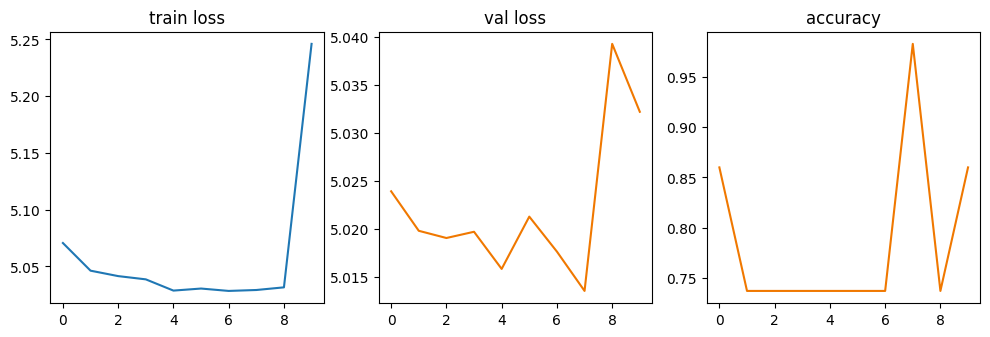

In [32]:
import matplotlib.pyplot as plt

epochs = [res['epoch'] for res in resultado]
train_losses = [res['train_loss'] for res in resultado]
val_losses = [res['val_loss'] for res in resultado]
val_accuracy = [res['val_accuracy'] for res in resultado]

plt.figure(figsize = (12,12))
plt.subplot(3,3,1)
plt.title('train loss')
plt.plot(epochs,train_losses,label='train losss')

plt.subplot(3,3,2)
plt.title('val loss')
plt.plot(epochs,val_losses,label='val loss',  color = '#f07800')

plt.subplot(3,3,3)
plt.title('accuracy')
plt.plot(epochs,val_accuracy,label='val loss',  color = '#f07800')
plt.show()

## Code to save the trained model and training info to a file

In [14]:
torch.save(model.state_dict(), 'modelSwin.pth')

In [18]:
import csv

# Specify the file name
filename = 'training_results.csv'

# Ensure that the resultado list is not empty
if resultado:
    # Get the keys from the first dictionary as column headers
    keys = resultado[0].keys()

    # Open the file in write mode
    with open(filename, 'w', newline='') as csvfile:
        # Create a DictWriter object
        dict_writer = csv.DictWriter(csvfile, fieldnames=keys)

        # Write the header
        dict_writer.writeheader()

        # Write the rows
        dict_writer.writerows(resultado)
